## 0. 기본 설정

In [1]:
# 라이브러리 import

import pandas as pd
import numpy as np
import random
import torch

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

plt.style.use('ggplot')

In [2]:
# 시드 고정

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

set_seed(42)

In [3]:
# 데이터 불러오기

origin_corn_df = pd.read_csv("/data/ephemeral/home/news_articles_resources_triples/corn_future_price.csv")
origin_wheat_df = pd.read_csv("/data/ephemeral/home/news_articles_resources_triples/wheat_future_price.csv")
origin_soybean_df = pd.read_csv("/data/ephemeral/home/news_articles_resources_triples/soybean_future_price.csv")
origin_article_df = pd.read_csv("/data/ephemeral/home/news_articles_resources_triples/news_articles_resources.csv")

## 1. 선물 가격 데이터 EDA

### 데이터 확인

In [4]:
# 결측치 확인 -> 없음

print(origin_corn_df.isna().sum().sum())
print(origin_wheat_df.isna().sum().sum())
print(origin_soybean_df.isna().sum().sum())

0
0
0


In [5]:
# 사용할 데이터 영역(2017-11-9 ~ 2025-11-14)만 추출

print(f"filter 전, {len(origin_corn_df)} {len(origin_wheat_df)} {len(origin_soybean_df)}")

origin_corn_df['time'] = pd.to_datetime(origin_corn_df['time'])
origin_wheat_df['time'] = pd.to_datetime(origin_wheat_df['time'])
origin_soybean_df['time'] = pd.to_datetime(origin_soybean_df['time'])

corn_df = origin_corn_df[(origin_corn_df['time'] >= pd.to_datetime("2017-11-09")) & (origin_corn_df['time'] <= pd.to_datetime("2025-11-14"))]
wheat_df = origin_wheat_df[(origin_wheat_df['time'] >= pd.to_datetime("2017-11-09")) & (origin_wheat_df['time'] <= pd.to_datetime("2025-11-14"))]
soybean_df = origin_soybean_df[(origin_soybean_df['time'] >= pd.to_datetime("2017-11-09")) & (origin_soybean_df['time'] <= pd.to_datetime("2025-11-14"))]

print(f"filter 후, {len(corn_df)} {len(wheat_df)} {len(soybean_df)}")

filter 전, 3824 2738 2670
filter 후, 2017 2017 2017


In [6]:
# 날짜가 일치하는지 확인 -> 일치

corn_dates = corn_df['time']
wheat_dates = wheat_df['time']
soybean_dates = soybean_df['time']

print("corn - wheat:", set(corn_dates) - set(wheat_dates))
print("corn - soybean:", set(corn_dates) - set(soybean_dates))

print("wheat - corn:", set(wheat_dates) - set(corn_dates))
print("wheat - soybean:", set(wheat_dates) - set(soybean_dates))

print("soybean - corn:", set(soybean_dates) - set(corn_dates))
print("soybean - wheat:", set(soybean_dates) - set(wheat_dates))

corn - wheat: set()
corn - soybean: set()
wheat - corn: set()
wheat - soybean: set()
soybean - corn: set()
soybean - wheat: set()


In [7]:
# 중복값 확인 -> 없음

print(corn_df.duplicated().sum())
print(wheat_df.duplicated().sum())
print(soybean_df.duplicated().sum())

0
0
0


### OHLC에 대한 시도표

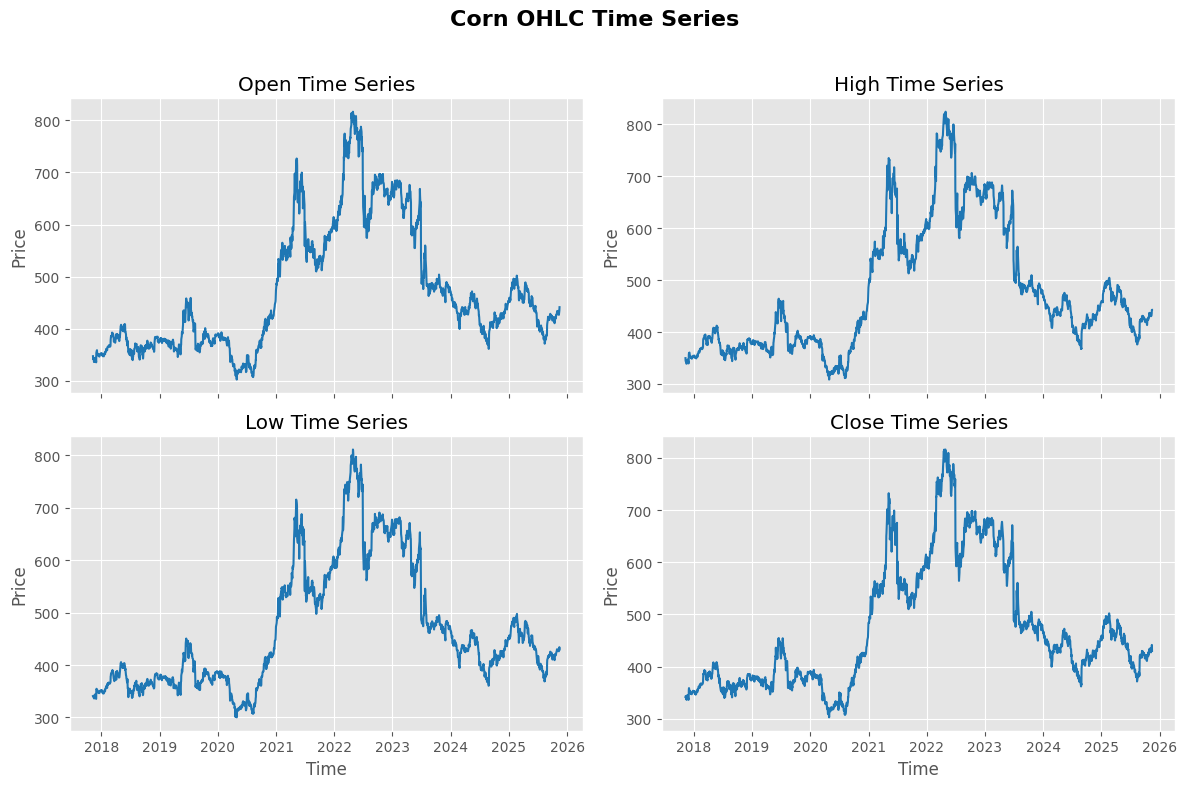

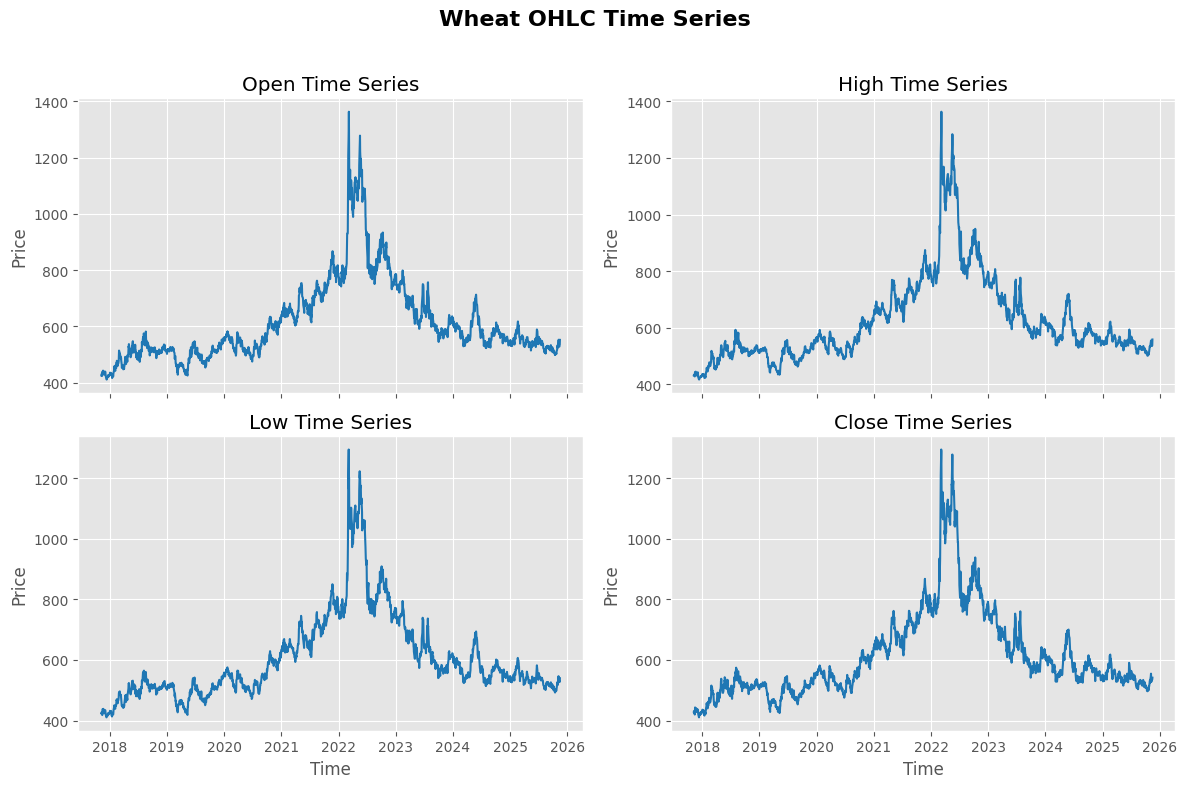

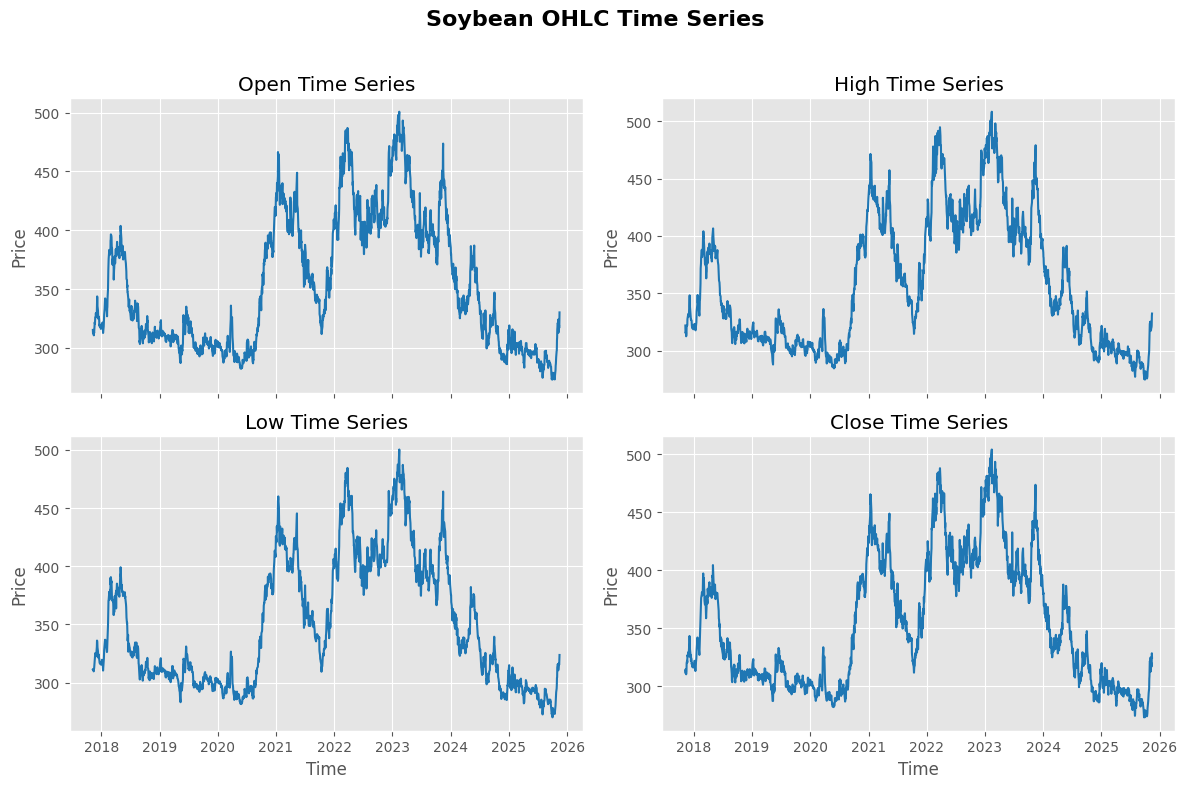

In [8]:
cols = ["open", "high", "low", "close"]

for data, name in zip([corn_df, wheat_df, soybean_df], ["Corn", "Wheat", "Soybean"]):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
    axes = axes.flatten()
    
    for i, col_name in enumerate(cols):
        axes[i].plot(data["time"], data[col_name], label=col_name, color='tab:blue')
        axes[i].set_title(f"{col_name.capitalize()} Time Series")
        axes[i].set_ylabel("Price")
        axes[i].grid(True)

    axes[-2].set_xlabel("Time") 
    axes[-1].set_xlabel("Time")

    fig.suptitle(f"{name} OHLC Time Series", fontsize=16, fontweight='bold')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

### 작물의 종가 간 상관관계

             Corn     Wheat   Soybean
Corn     1.000000  0.898689  0.784098
Wheat    0.898689  1.000000  0.682495
Soybean  0.784098  0.682495  1.000000


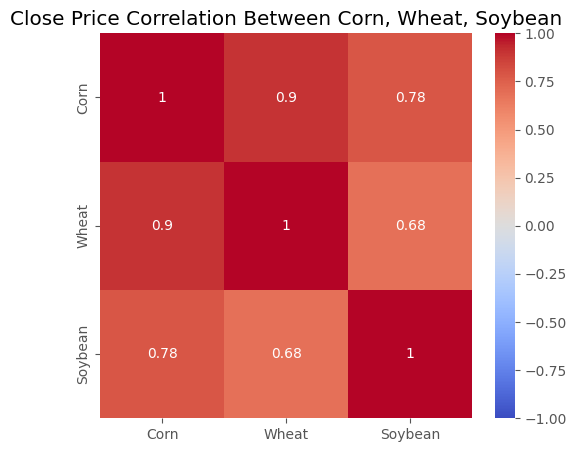

In [9]:
price_df = pd.DataFrame({
    "Corn": corn_df["close"].values,
    "Wheat": wheat_df["close"].values,
    "Soybean": soybean_df["close"].values
}, index=corn_df["time"])

corr_matrix = price_df.corr()
print(corr_matrix)

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Close Price Correlation Between Corn, Wheat, Soybean")
plt.show()

### 작물 별 캔들차트

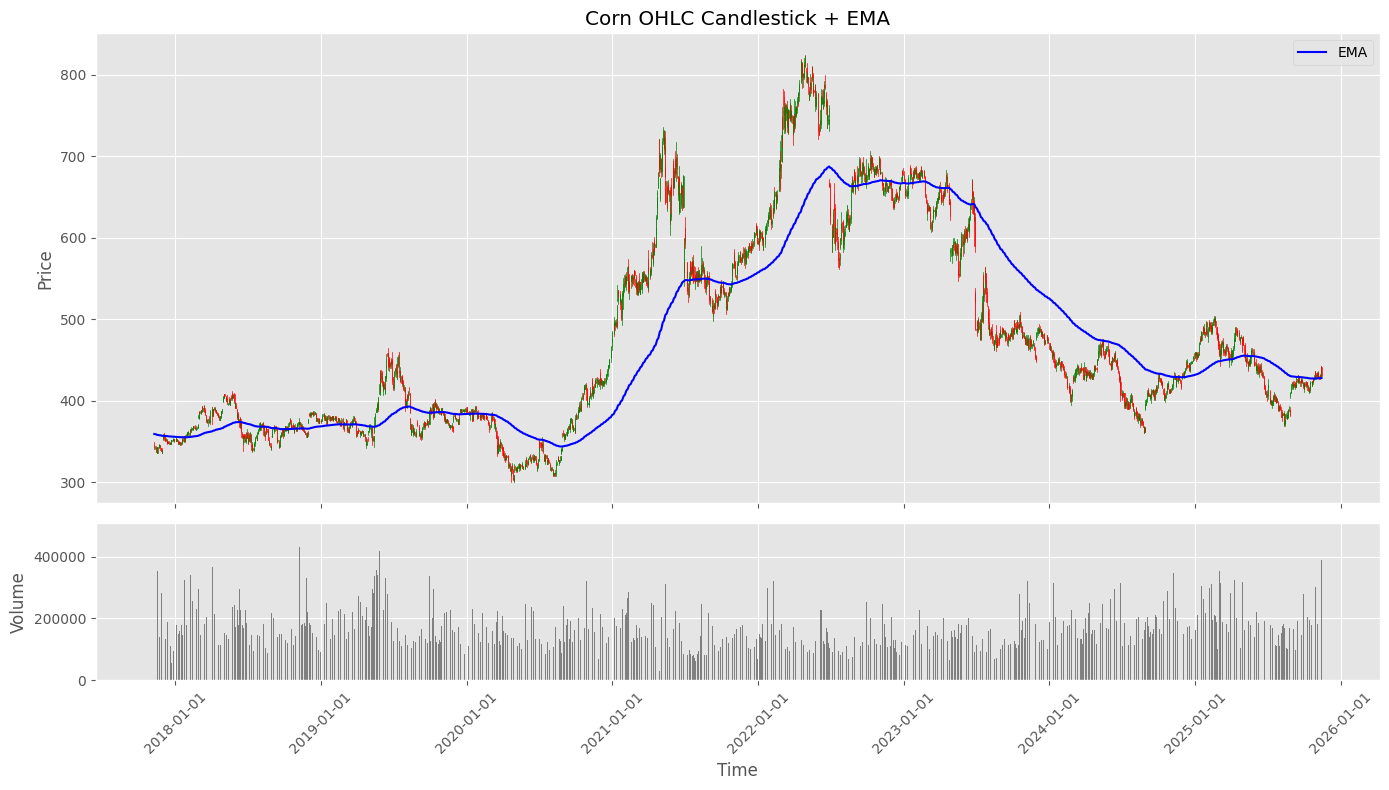

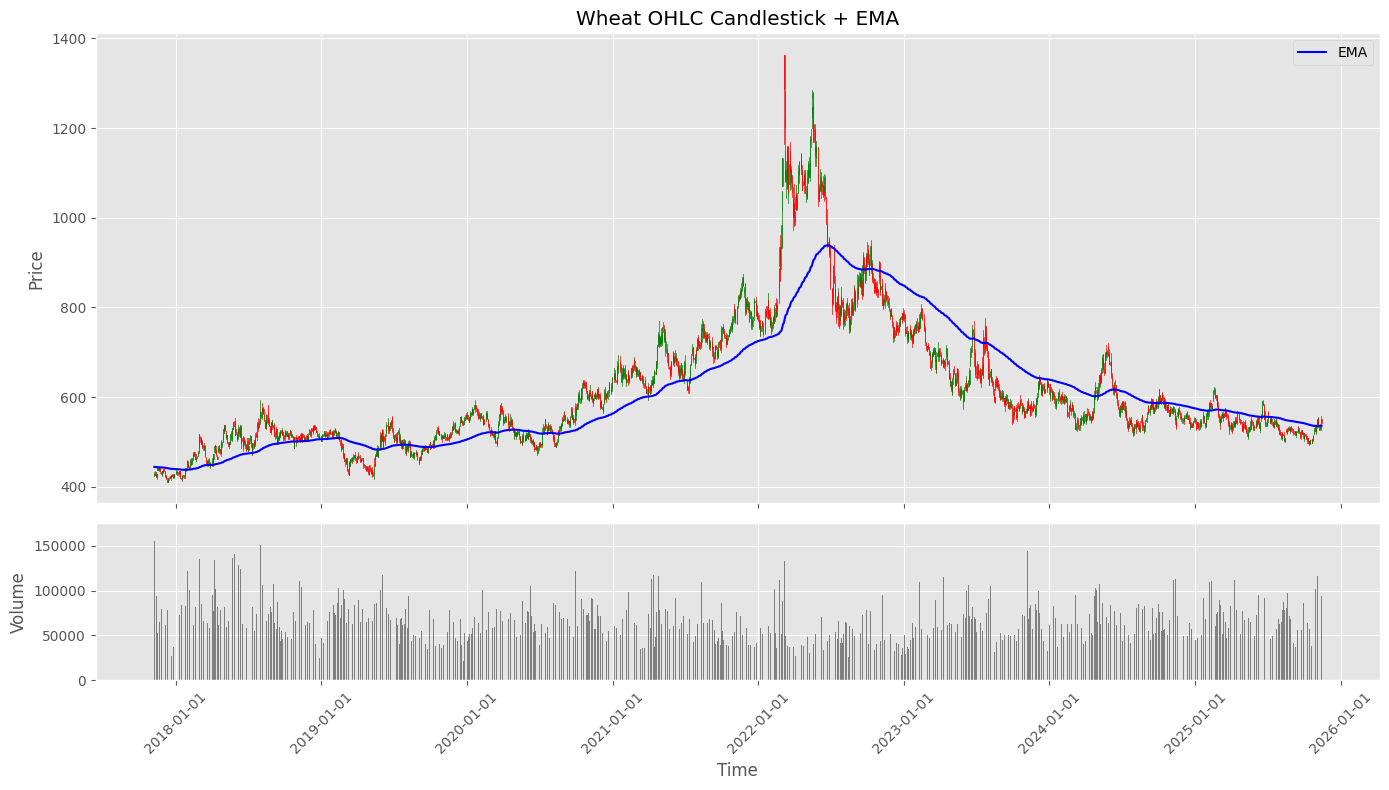

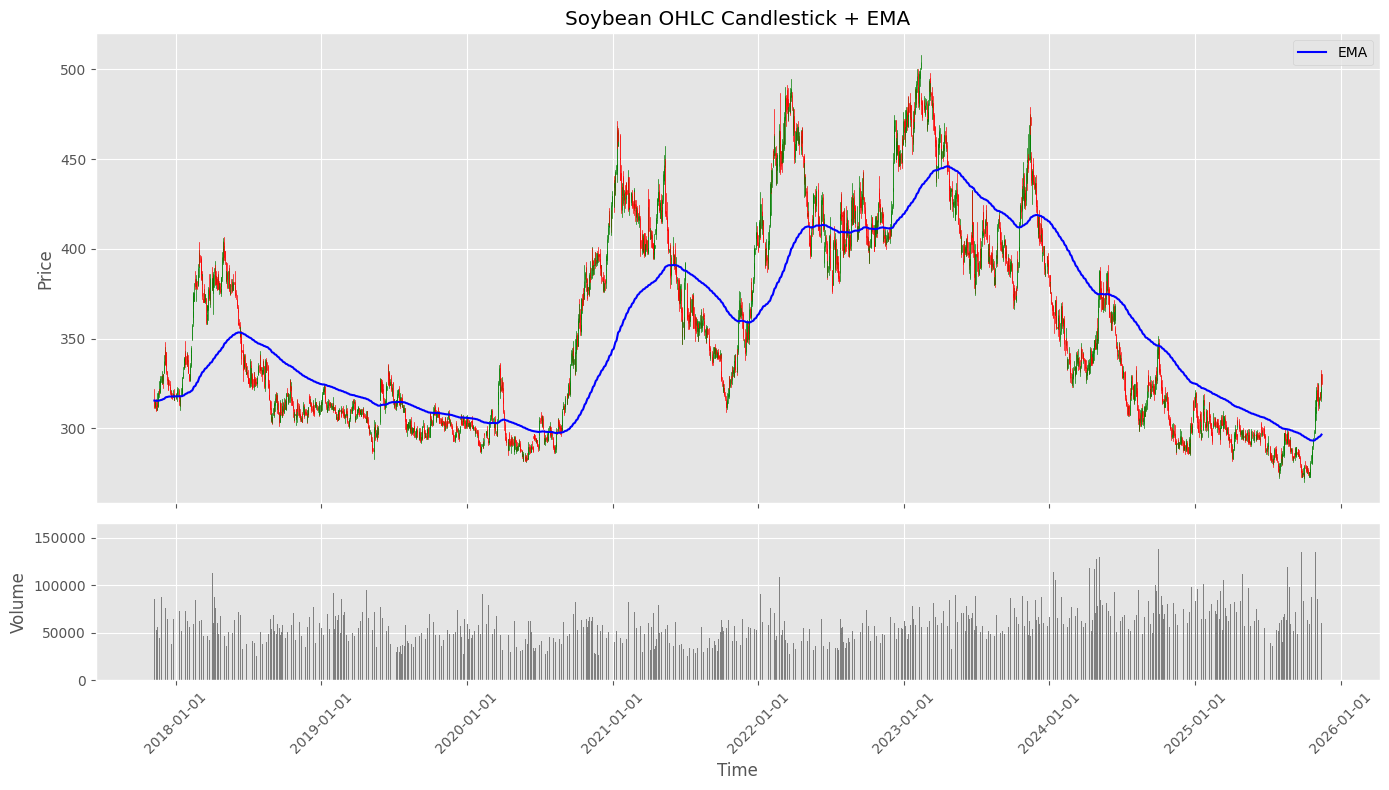

In [10]:
for data, name in zip([corn_df, wheat_df, soybean_df], ["Corn", "Wheat", "Soybean"]):
    ohlc_df = data.copy()
    ohlc_df['time_num'] = mdates.date2num(ohlc_df['time'])

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,8), sharex=True,
                                   gridspec_kw={'height_ratios': [3, 1]})

    ohlc_data = ohlc_df[['time_num','open','high','low','close']].values

    candlestick_ohlc(ax1, ohlc_data, width=0.6, colorup='g', colordown='r', alpha=0.8)

    ax1.plot(ohlc_df['time_num'], ohlc_df['EMA'], color='blue', label='EMA')

    ax1.set_ylabel('Price')
    ax1.set_title(f'{name} OHLC Candlestick + EMA')
    ax1.grid(True)
    ax1.legend()

    ax1.xaxis_date()
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    ax2.bar(ohlc_df['time_num'], ohlc_df['Volume'], color='grey', width=0.6)
    ax2.set_ylabel('Volume')
    ax2.set_xlabel('Time')
    ax2.grid(True)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

- 전반적인 추세는 없다고 판단

### 변동성 시각화

In [11]:
for data, origin_data in zip([corn_df, wheat_df, soybean_df], [origin_corn_df, origin_wheat_df, origin_soybean_df]):
    origin_data['log_return'] = np.log(origin_data['close'] / origin_data['close'].shift(1))
    origin_data['volatility_7d'] = origin_data['log_return'].rolling(window=7).std()
    origin_data['volatility_30d'] = origin_data['log_return'].rolling(window=30).std()
    
cols = ['time', 'log_return', 'volatility_7d', 'volatility_30d']

corn_df = pd.merge(corn_df, origin_corn_df[cols], how='left', on='time')
wheat_df = pd.merge(wheat_df, origin_wheat_df[cols], how='left', on='time')
soybean_df = pd.merge(soybean_df, origin_soybean_df[cols], how='left', on='time')

corn_df.head()

time    open    high     low   close         EMA  Volume  log_return  \
0 2017-11-09  347.50  349.75  340.75  341.50  359.237260  475087   -0.019573   
1 2017-11-10  341.75  344.00  341.00  343.50  359.080670  349164    0.005839   
2 2017-11-13  343.50  344.00  341.50  342.25  358.913201  289722   -0.003646   
3 2017-11-14  342.00  342.25  337.25  337.50  358.700134  220983   -0.013976   
4 2017-11-15  337.25  339.00  337.00  338.25  358.496650  217010    0.002220   

   volatility_7d  volatility_30d  
0       0.009121        0.007774  
1       0.008910        0.007706  
2       0.008104        0.007513  
3       0.009023        0.007840  
4       0.009291        0.007850

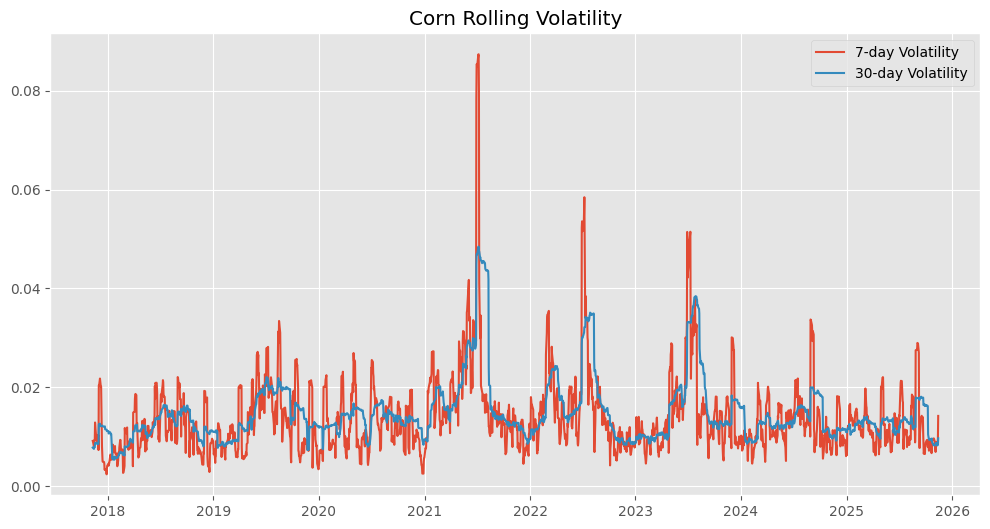

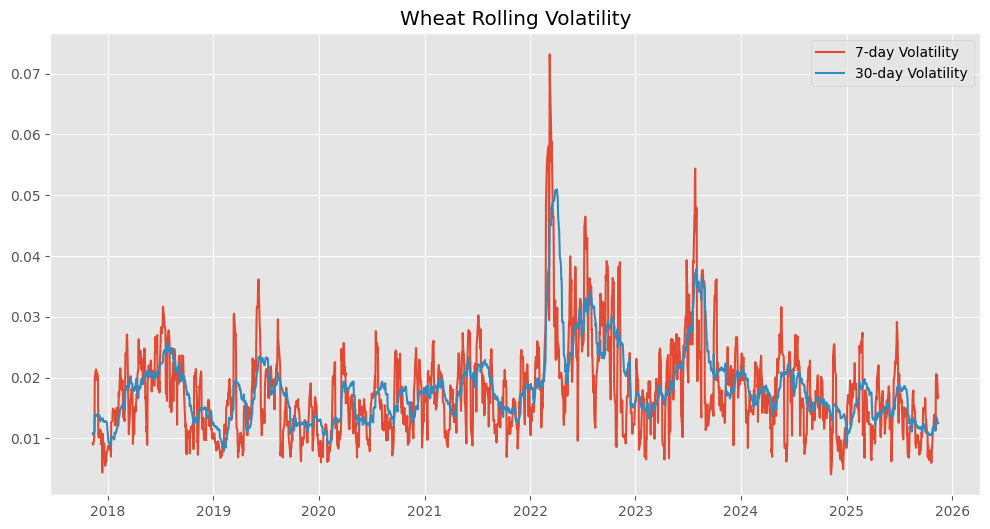

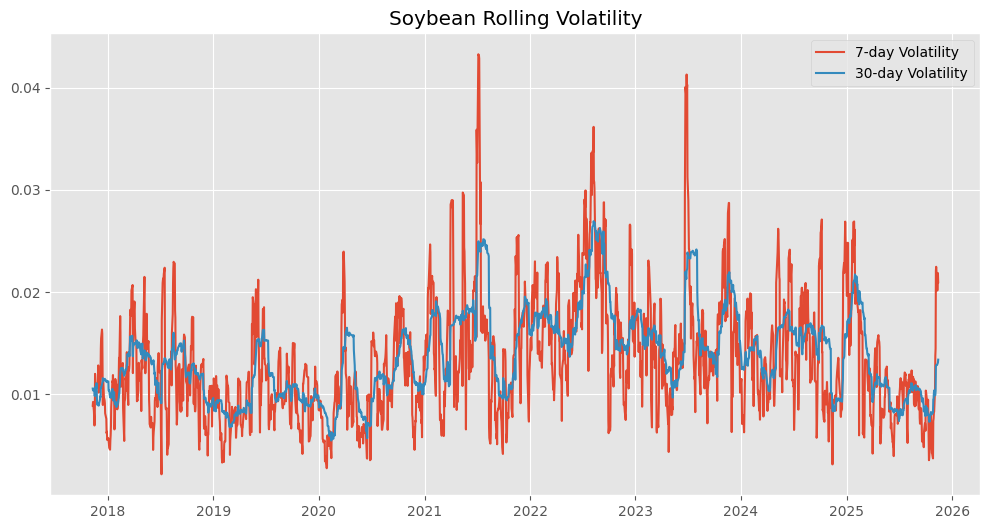

In [12]:
for data, name in zip([corn_df, wheat_df, soybean_df], ["Corn", "Wheat", "Soybean"]):
    plt.figure(figsize=(12,6))
    plt.plot(data['time'], data['volatility_7d'], label='7-day Volatility')
    plt.plot(data['time'], data['volatility_30d'], label='30-day Volatility')
    plt.legend()
    plt.title(f'{name} Rolling Volatility')
    plt.show()

- soybean이 유독 변동성이 심함

### log_return 분포

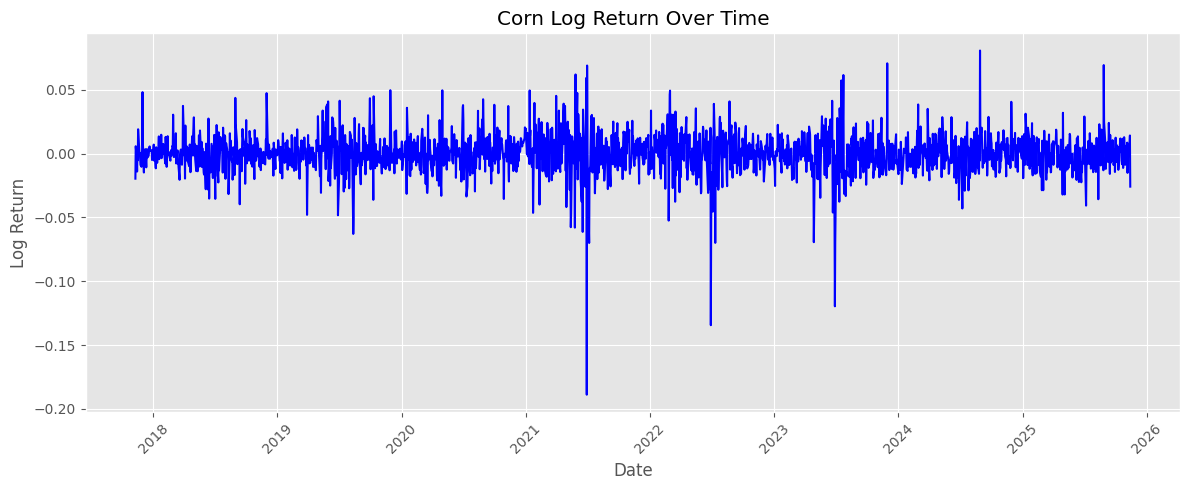

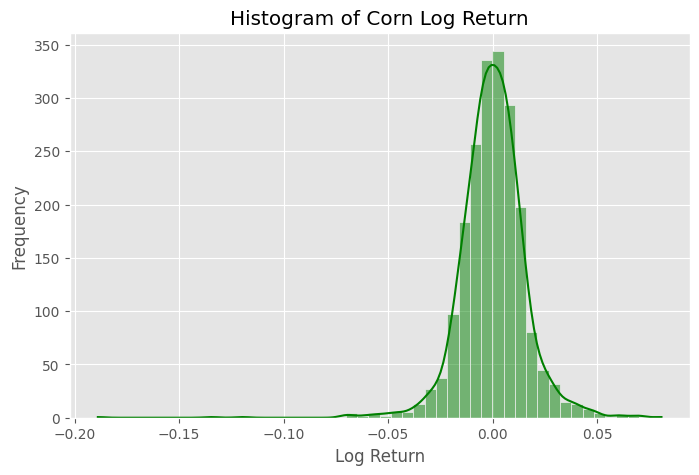

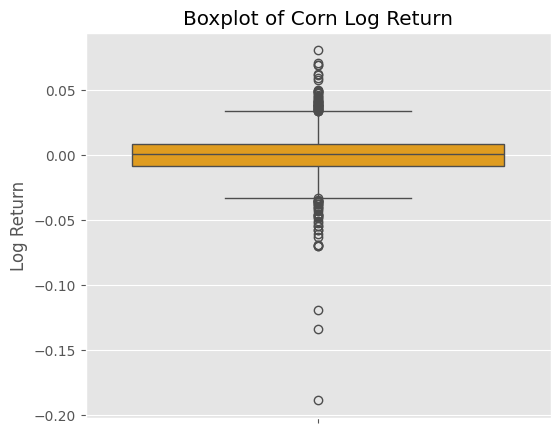

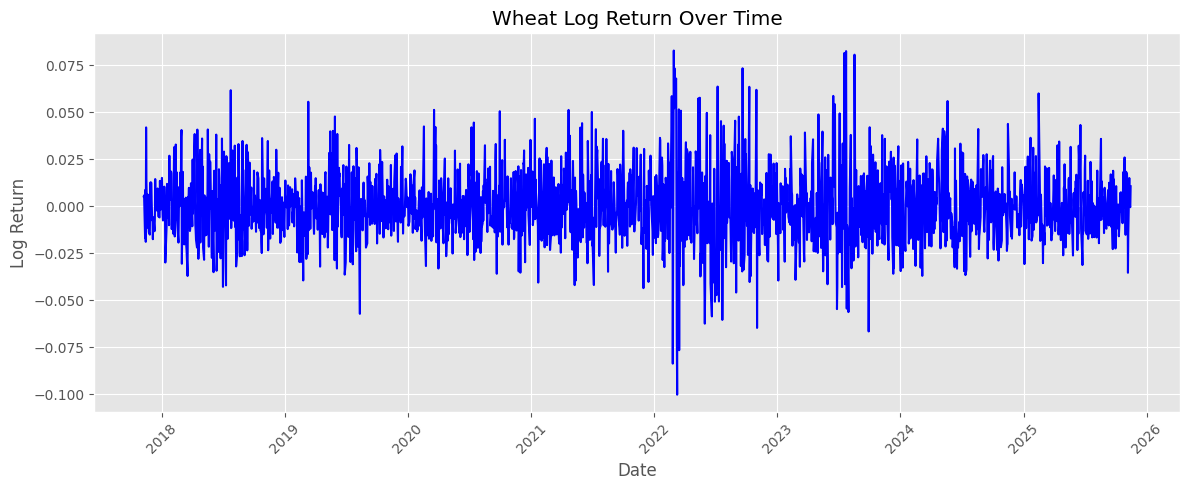

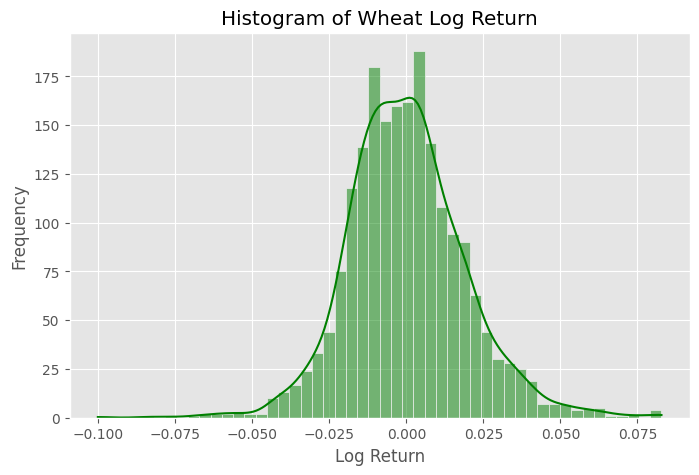

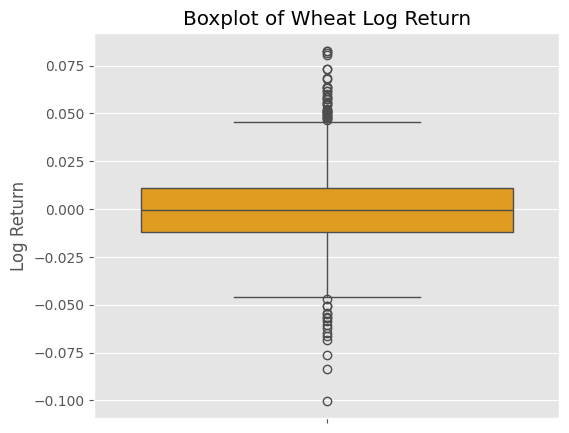

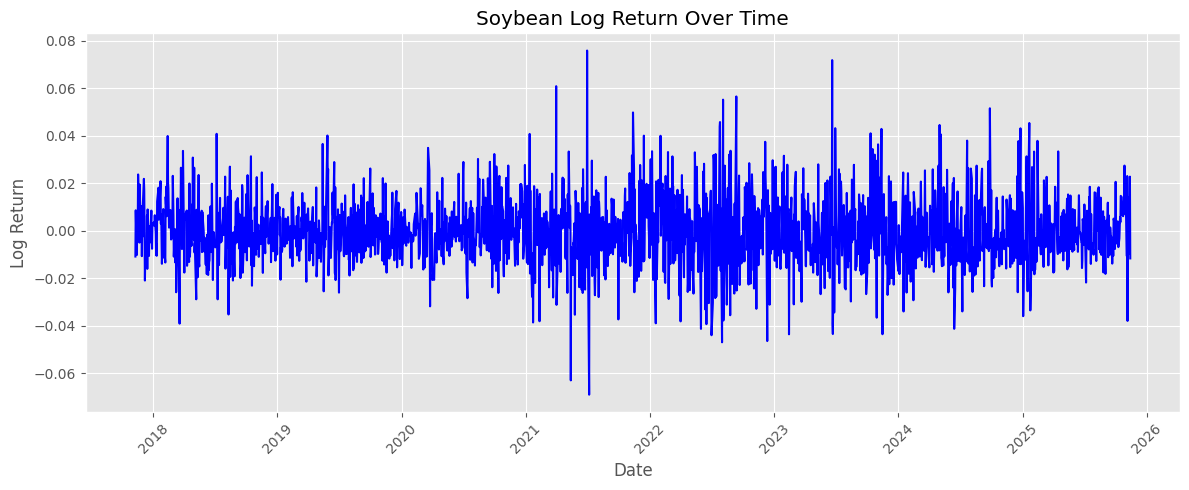

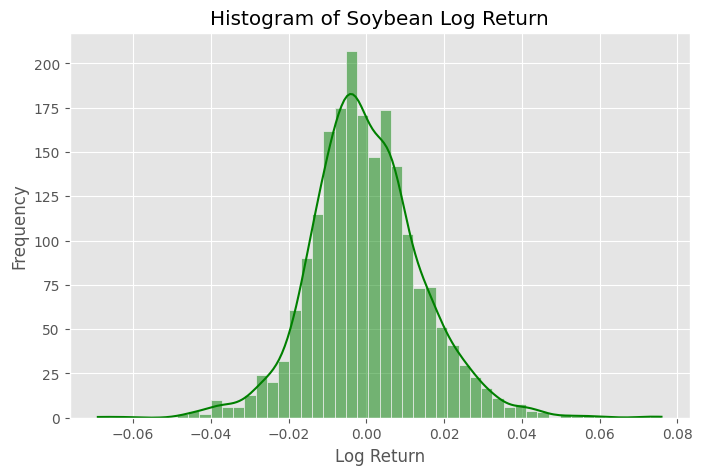

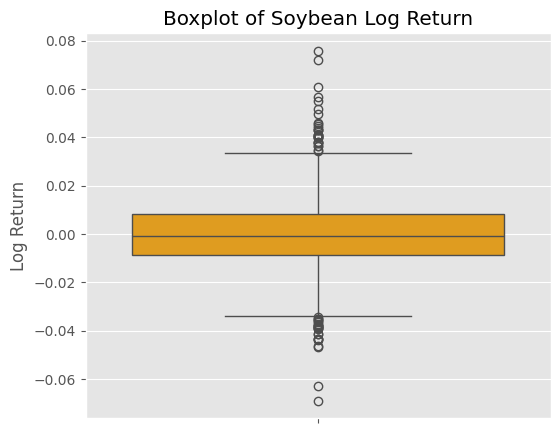

In [13]:
for data, name in zip([corn_df, wheat_df, soybean_df], ["Corn", "Wheat", "Soybean"]):
    plt.figure(figsize=(12, 5))
    plt.plot(data['time'], data['log_return'], color='blue')
    plt.title(f'{name} Log Return Over Time')
    plt.xlabel('Date')
    plt.ylabel('Log Return')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.histplot(data['log_return'], bins=50, kde=True, color='green')
    plt.title(f'Histogram of {name} Log Return')
    plt.xlabel('Log Return')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(6, 5))
    sns.boxplot(y=data['log_return'], color='orange')
    plt.title(f'Boxplot of {name} Log Return')
    plt.ylabel('Log Return')
    plt.show()

- 몇 이상치가 존재하긴 하지만, 대부분 표준정규분포 -> close 대신 log return을 타켓으로 설정

## 2. 기사 데이터 EDA

### 데이터 확인

In [14]:
# 사용할 데이터인 filter_status가 True인 기사만 추출

print(f"filter 전, {len(origin_article_df)}")

article_df = origin_article_df[origin_article_df["filter_status"] == 'T']

print(f"filter 후, {len(article_df)}")

filter 전, 296514
filter 후, 103443


In [15]:
# 결측치 확인

article_df.isna().sum()

id                       0
title                    0
doc_url                  0
all_text                31
authors              13509
publish_date             0
meta_site_name           0
key_word                 0
filter_status            0
description              0
named_entities           0
triples                  0
article_embedding        0
dtype: int64

- authors와 all_text는 실제 분석에서 사용할 예정 X → 무시하고 진행

In [16]:
# 중복값 확인 -> 없음

print(article_df.duplicated().sum())

0


### 데이터의 filter_status의 기준 파악

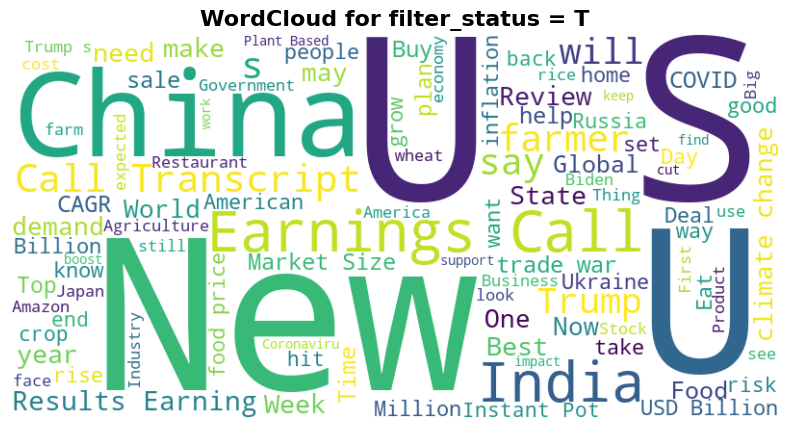

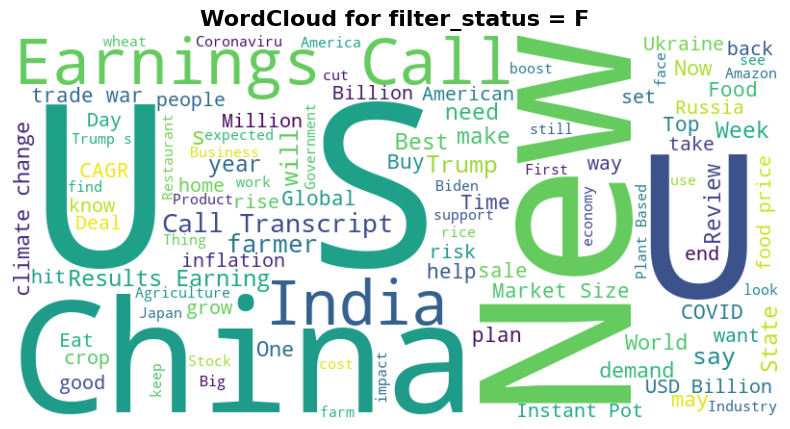

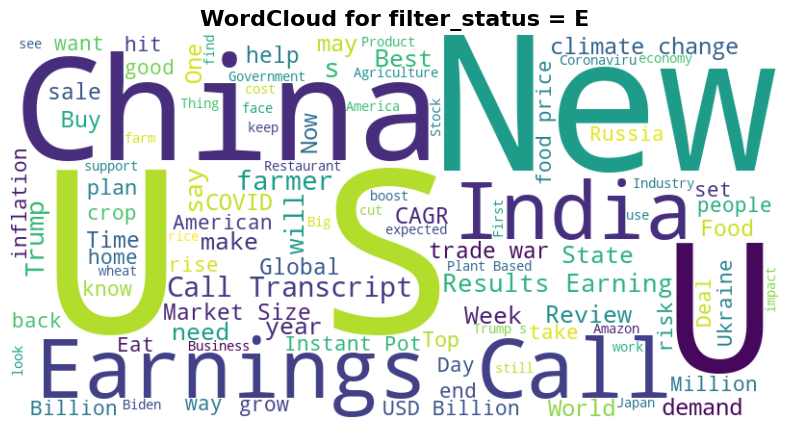

In [17]:
# 각 filter_status 별 wordcloud (title 기준)

def plot_wordcloud(text, title, max_words=100):
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=max_words).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.show()

statuses = ['T', 'F', 'E']

for status in statuses:
    df_status = origin_article_df[origin_article_df['filter_status'] == status]
    all_keywords = " ".join(origin_article_df['title'].dropna())
    plot_wordcloud(all_keywords, f"WordCloud for filter_status = {status}")

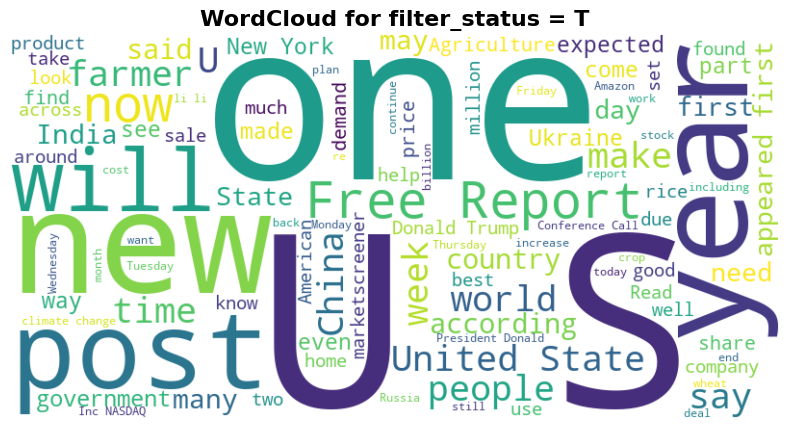

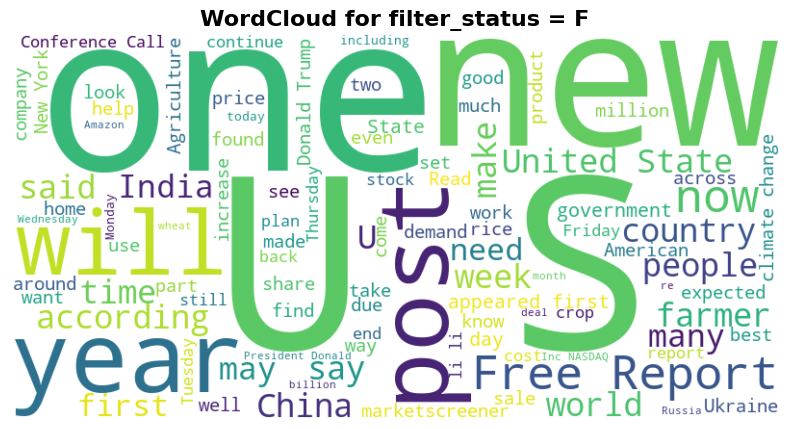

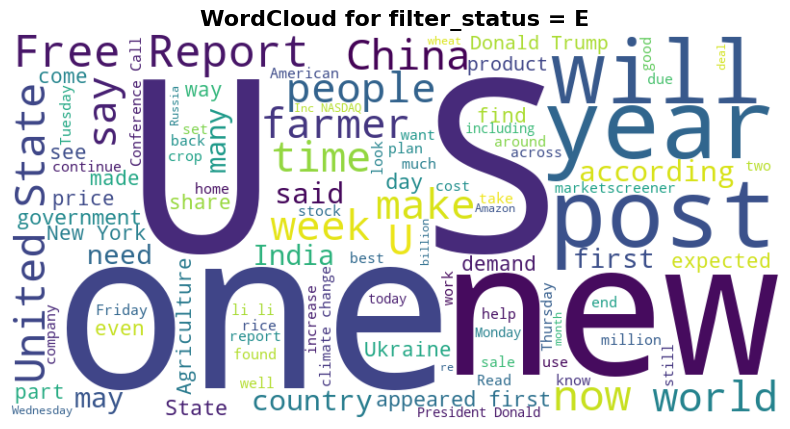

In [18]:
# 각 filter_status 별 wordcloud (description 기준)

for status in statuses:
    df_status = origin_article_df[origin_article_df['filter_status'] == status]
    all_keywords = " ".join(origin_article_df['description'].dropna())
    plot_wordcloud(all_keywords, f"WordCloud for filter_status = {status}")

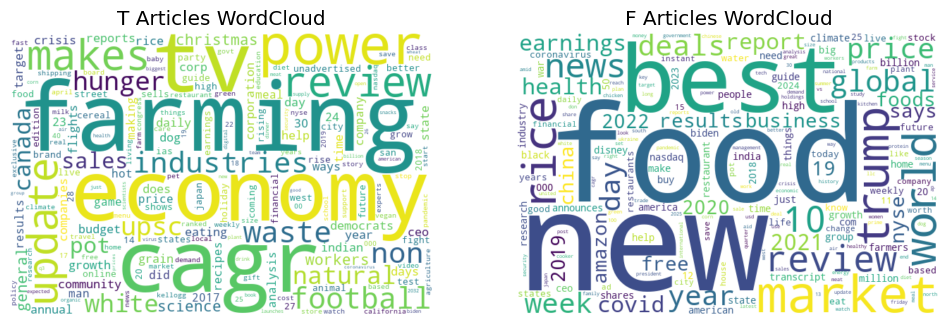

In [19]:
# tf-idf 기준 T/F wordcloud (title 기준)

t_texts = origin_article_df[origin_article_df['filter_status']=='T']['title'].dropna()
f_texts = origin_article_df[origin_article_df['filter_status']=='F']['title'].dropna()

vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
t_tfidf = vectorizer.fit_transform(t_texts)
f_tfidf = vectorizer.fit_transform(f_texts)

t_scores = np.array(t_tfidf.sum(axis=0)).flatten()
f_scores = np.array(f_tfidf.sum(axis=0)).flatten()

t_words = dict(zip(vectorizer.get_feature_names_out(), t_scores))
f_words = dict(zip(vectorizer.get_feature_names_out(), f_scores))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
WordCloud(width=600, height=400, background_color='white').generate_from_frequencies(t_words)
plt.imshow(WordCloud(width=600, height=400, background_color='white').generate_from_frequencies(t_words), interpolation='bilinear')
plt.axis('off')
plt.title("T Articles WordCloud")

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=600, height=400, background_color='white').generate_from_frequencies(f_words), interpolation='bilinear')
plt.axis('off')
plt.title("F Articles WordCloud")

plt.show()

- T인 데이터: farming · economy · cagr
    - 산업/거시 관점 단어들이 두드러짐
    - 특히, CAGR는 성장률, 정량적·분석적 지표
- F인 데이터: best · food · new
    - 마케팅/소비자 지향 단어들

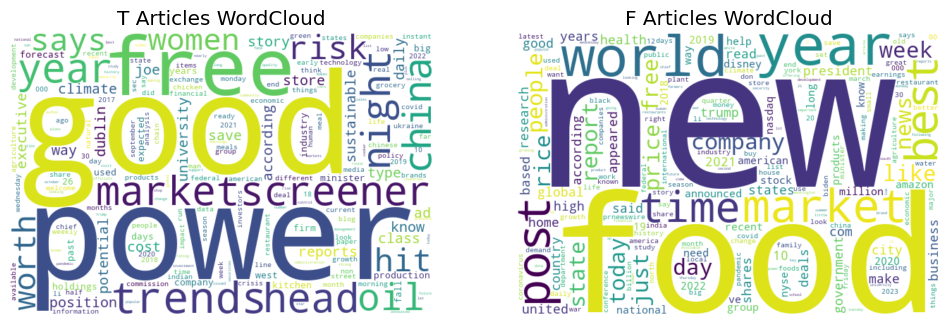

In [20]:
# tf-idf 기준 T/F wordcloud (description 기준)

t_texts = origin_article_df[origin_article_df['filter_status']=='T']['description'].dropna()
f_texts = origin_article_df[origin_article_df['filter_status']=='F']['description'].dropna()

vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
t_tfidf = vectorizer.fit_transform(t_texts)
f_tfidf = vectorizer.fit_transform(f_texts)

t_scores = np.array(t_tfidf.sum(axis=0)).flatten()
f_scores = np.array(f_tfidf.sum(axis=0)).flatten()

t_words = dict(zip(vectorizer.get_feature_names_out(), t_scores))
f_words = dict(zip(vectorizer.get_feature_names_out(), f_scores))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
WordCloud(width=600, height=400, background_color='white').generate_from_frequencies(t_words)
plt.imshow(WordCloud(width=600, height=400, background_color='white').generate_from_frequencies(t_words), interpolation='bilinear')
plt.axis('off')
plt.title("T Articles WordCloud")

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=600, height=400, background_color='white').generate_from_frequencies(f_words), interpolation='bilinear')
plt.axis('off')
plt.title("F Articles WordCloud")

plt.show()

- T인 데이터: good · power · market
    - 시장 내 위치, 영향력, 경쟁 구조를 설명하는 분석형 서술를 가짐
- F인 데이터: year · new · food
    - 정보성은 있지만 분석 깊이는 낮음
- 따라서, 분석에서는 T인 데이터만 가지고 예측하기로 결정함

### 전체 발행 기사의 수 분포

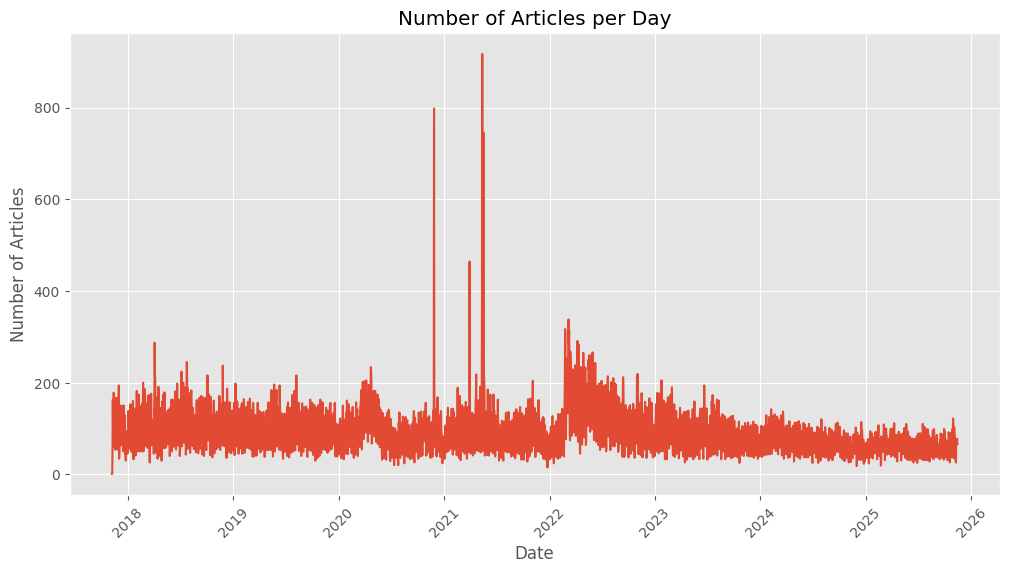

In [21]:
origin_article_df['publish_date'] = pd.to_datetime(origin_article_df['publish_date']).dt.date
daily_counts = origin_article_df.groupby('publish_date').size().reset_index(name='article_count')

plt.figure(figsize=(12,6))
plt.plot(daily_counts['publish_date'], daily_counts['article_count'])
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.title('Number of Articles per Day')
plt.grid(True)
plt.show()

- 기사의 수가 튀는 부분은 코로나에 영향이 있을 수도 있다고 판단

## 3. 가격 + 기사 데이터 EDA

In [22]:
# 종가 가격만 모은 데이터셋 생성
df_price = pd.merge(
    corn_df[['time', 'close']].rename(columns={'close':'corn_close'}),
    wheat_df[['time', 'close']].rename(columns={'close':'wheat_close'}),
    on='time',
    how='inner'
)
df_price = pd.merge(
    df_price,
    soybean_df[['time', 'close']].rename(columns={'close':'soybean_close'}),
    on='time',
    how='inner'
)
df_price.head()

time  corn_close  wheat_close  soybean_close
0 2017-11-09      341.50       429.00          311.8
1 2017-11-10      343.50       431.50          314.5
2 2017-11-13      342.25       424.25          311.3
3 2017-11-14      337.50       428.00          310.3
4 2017-11-15      338.25       420.00          311.3

### 전체 발행 기사와 종가의 상관관계

               article_count  corn_close  wheat_close  soybean_close
article_count       1.000000    0.291166     0.354150       0.314393
corn_close          0.291166    1.000000     0.898689       0.784098
wheat_close         0.354150    0.898689     1.000000       0.682495
soybean_close       0.314393    0.784098     0.682495       1.000000


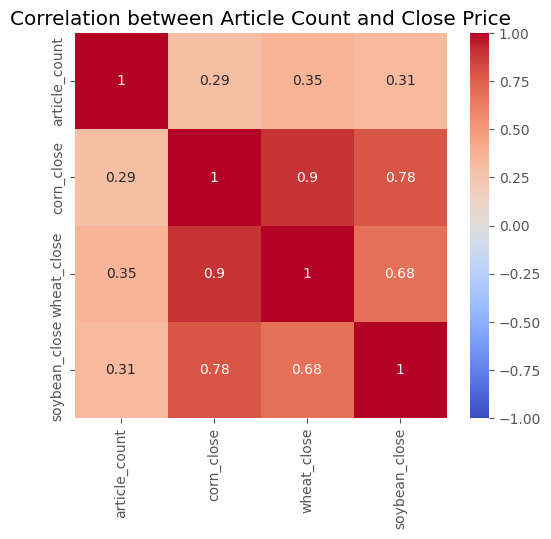

In [23]:
daily_counts['publish_date'] = pd.to_datetime(daily_counts['publish_date'])

merged_df = pd.merge(daily_counts, df_price, left_on='publish_date', right_on='time', how='inner')

corr_matrix = merged_df[["article_count", "corn_close", "wheat_close", "soybean_close"]].corr()
print(corr_matrix)

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Correlation between Article Count and Close Price')
plt.show()

### 전체 발행 기사의 수와 종가의 시도표

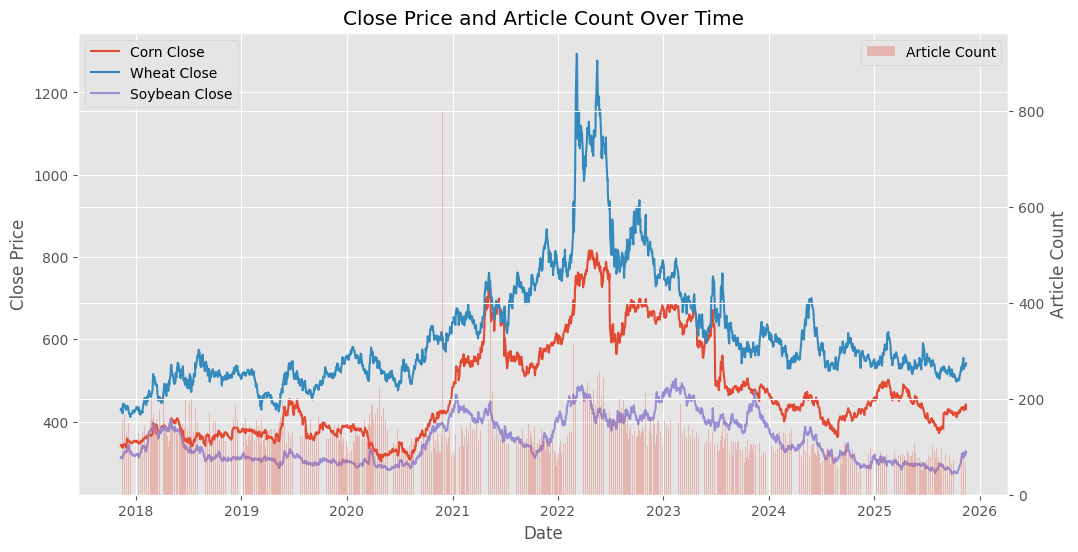

In [24]:
fig, ax1 = plt.subplots(figsize=(12, 6))

merged_df['publish_date'] = pd.to_datetime(merged_df['publish_date'])

ax1.plot(merged_df['publish_date'], merged_df['corn_close'], label='Corn Close')
ax1.plot(merged_df['publish_date'], merged_df['wheat_close'], label='Wheat Close')
ax1.plot(merged_df['publish_date'], merged_df['soybean_close'], label='Soybean Close')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.bar(merged_df['publish_date'], merged_df['article_count'], alpha=0.3, label='Article Count')
ax2.set_ylabel('Article Count')
ax2.legend(loc='upper right')

plt.xticks(rotation=45)
plt.title('Close Price and Article Count Over Time')
plt.grid(True)
plt.show()

### 전체 발행 기사의 수와 변동성 시각화

/tmp/ipykernel_3814817/1736395497.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['news_count'].fillna(0, inplace=True)


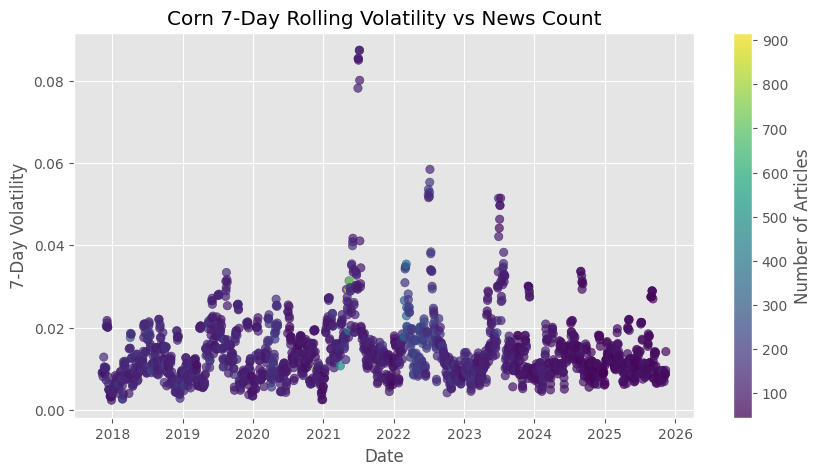

/tmp/ipykernel_3814817/1736395497.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['news_count'].fillna(0, inplace=True)


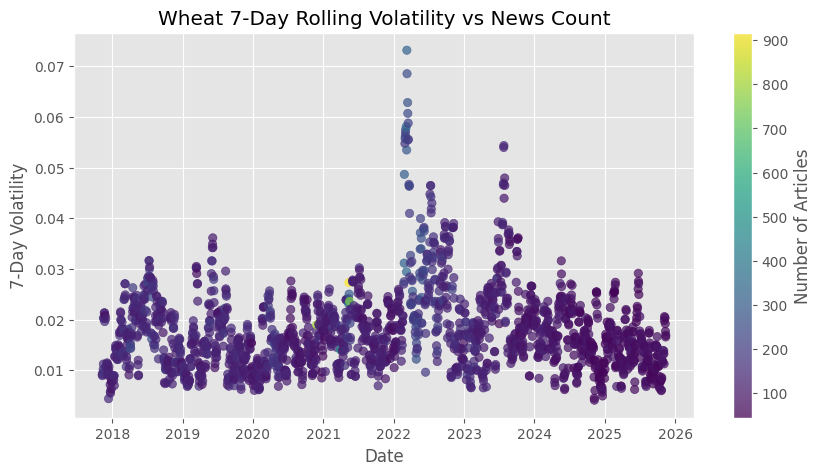

/tmp/ipykernel_3814817/1736395497.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['news_count'].fillna(0, inplace=True)


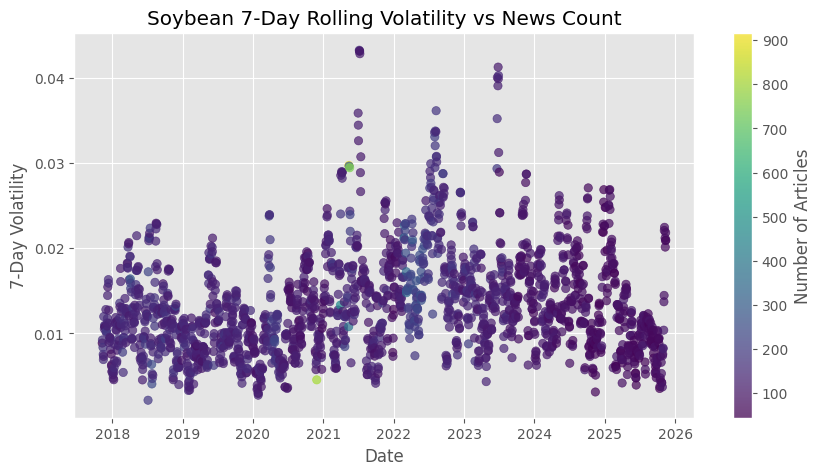

In [25]:
origin_article_df['publish_date'] = pd.to_datetime(origin_article_df['publish_date'])
daily_articles = origin_article_df.groupby('publish_date').size()

for data, name in zip([corn_df, wheat_df, soybean_df], ["Corn", "Wheat", "Soybean"]):
    df = data.merge(daily_articles.rename('news_count'), left_on='time', right_index=True, how='left')
    df['news_count'].fillna(0, inplace=True)

    plt.figure(figsize=(10,5))
    sc = plt.scatter(df['time'], df['volatility_7d'], c=df['news_count'], cmap='viridis', alpha=0.7)
    plt.colorbar(sc, label='Number of Articles')
    plt.title(f'{name} 7-Day Rolling Volatility vs News Count')
    plt.xlabel('Date')
    plt.ylabel('7-Day Volatility')
    plt.show()

- 판단이 어려워 변동성 구간을 나눠 확인하고자 함

### 변동성 구간에 따른 전체 발행 기사의 수

In [26]:
daily_articles = daily_articles.rename('news_count')
daily_articles = pd.DataFrame(daily_articles)

for data, name in zip([corn_df, wheat_df, soybean_df], ["Corn", "Wheat", "Soybean"]):
    merged = data.merge(daily_articles, left_on='time', right_index=True, how='left')
    merged['news_count'].fillna(0, inplace=True)

    q_low = merged['volatility_7d'].quantile(0.33)
    q_high = merged['volatility_7d'].quantile(0.66)

    merged['vol_regime'] = pd.cut(
        merged['volatility_7d'],
        bins=[-1, q_low, q_high, 1],
        labels=['Low', 'Mid', 'High']
    )
    
    print(merged.groupby('vol_regime')['news_count'].mean())

vol_regime
Low     117.333333
Mid     117.242105
High    133.578717
Name: news_count, dtype: float64
vol_regime
Low     113.944444
Mid     118.654135
High    135.500000
Name: news_count, dtype: float64
vol_regime
Low     117.606607
Mid     121.251128
High    129.427114
Name: news_count, dtype: float64


/tmp/ipykernel_3814817/2748039803.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged['news_count'].fillna(0, inplace=True)
/tmp/ipykernel_3814817/2748039803.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(merged.groupby('vol_regime')['news_count'].mean())
/tmp/ipykernel_3814817/2748039803.py:6: FutureWarning: A value is

- 변동성이 high 영역일 때 기사가 많이 나오긴 한다

### 뉴스의 수와 +lag 시점의 return과의 상관관계

0 -0.019224090949357793
1 -0.024472134223464715
2 -0.01489131484637258
3 0.0011068115706285098
4 0.002524559508736188
5 -0.004331557583929461
6 -0.04636154472942285
7 -0.0264432651022206
8 -0.024329010123253527
9 -0.0026629840232028925
10 0.04382574819473292


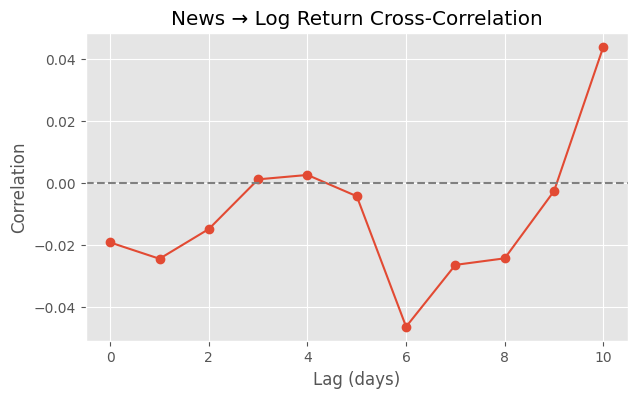

0 -0.008000257937319549
1 -0.012184470731421222
2 -0.036568754290122255
3 -0.01638063709609006
4 -0.01069679883514262
5 -0.025071832191254886
6 -0.01105129985261249
7 -0.04638632372705754
8 -0.014969577729272768
9 0.005689990233081858
10 0.006332137251950808


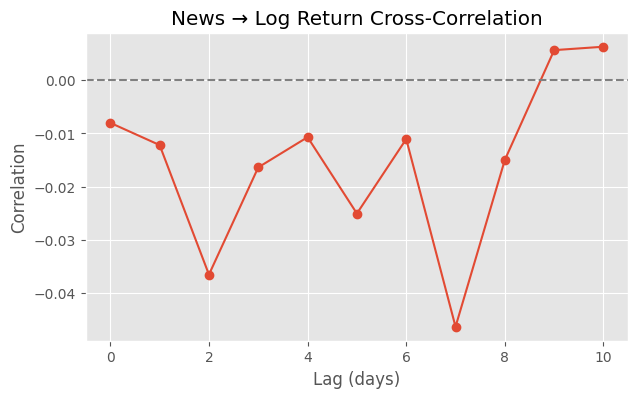

0 -0.026487221889016286
1 -0.02015755292470479
2 -0.024332576227918068
3 -0.04719236253400653
4 -0.028880671385440447
5 -0.04308681674997213
6 -0.02615361231328728
7 -0.03921693822962727
8 -0.02851539336142248
9 -0.02096208669330003
10 0.002763616952322638


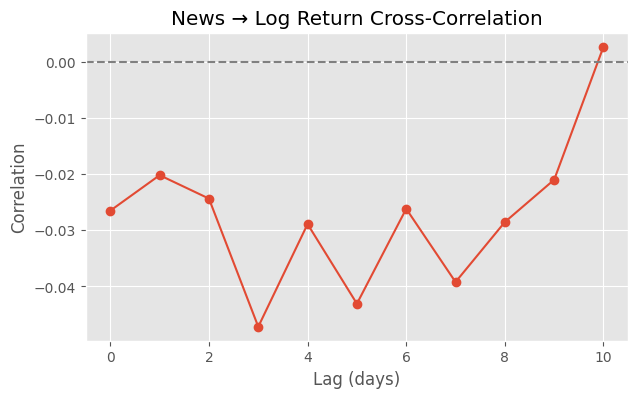

In [27]:
def cross_corr(x, y, max_lag=10):
    lags = range(0, max_lag + 1)
    corr = []
    for lag in lags:
        corr.append(x.corr(y.shift(-lag)))
    return lags, corr

for data, name in zip([corn_df, wheat_df, soybean_df], ["Corn", "Wheat", "Soybean"]):
    merged = data.merge(daily_articles, left_on='time', right_index=True, how='left')
    merged = merged.sort_values('time').reset_index(drop=True)
    merged['news_count'] = merged['news_count'].fillna(0)

    lags, corr_ret = cross_corr(
        merged['news_count'],
        merged['log_return'],
        max_lag=10
    )
    
    for i, j in zip(lags, corr_ret):
        print(i, j)
    
    plt.figure(figsize=(7,4))
    plt.plot(lags, corr_ret, marker='o')
    plt.axhline(0, color='gray', linestyle='--')
    plt.xlabel('Lag (days)')
    plt.ylabel('Correlation')
    plt.title('News → Log Return Cross-Correlation')
    plt.show()

- Corn: 전 구간에서 0 근처, sign도 안정적 X -> 옥수수 가격 방향은 뉴스에 반응 X
- Wheat: 절대값은 작지만 대부분 음수 -> 뉴스에 의해 하락 압력 but 강력한 반응 X
- Soybean: 절대값은 작지만 대부분 음수 -> 뉴스에 의해 단기 하락 압력 but 강력한 반응 X

### 뉴스의 수와 +lag 시점의 7일 간의 변동성과의 상관관계

0 0.1411586364624869
1 0.14986353396062313
2 0.15435248413060226
3 0.15022730456858777
4 0.14530984854998
5 0.1463167410950498
6 0.1498721496839949
7 0.1325460933722921
8 0.1396505236040457
9 0.13335655055237491
10 0.13929697165505847


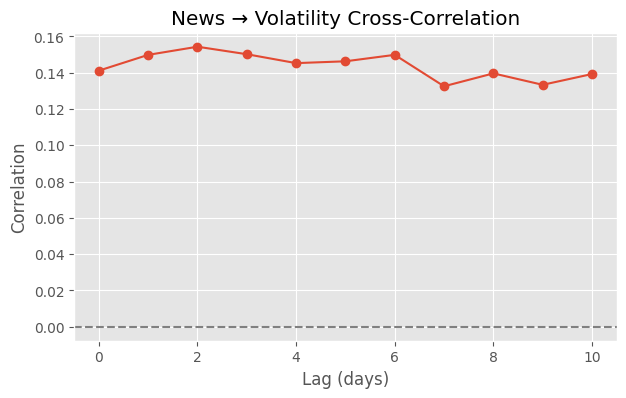

0 0.28693925946885884
1 0.2966679096925768
2 0.3008912091006405
3 0.30083096746261706
4 0.28757556418893243
5 0.269588607756917
6 0.25765730809343573
7 0.23651480534479935
8 0.23573277164412626
9 0.23275569591418224
10 0.24655182188676814


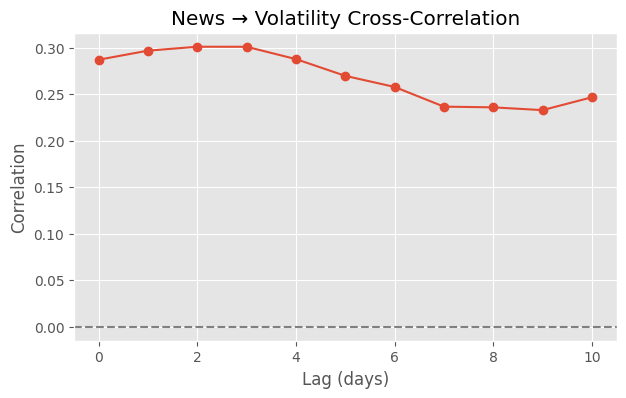

0 0.12097050007306484
1 0.13732496837369498
2 0.13666766013264287
3 0.12975589483600405
4 0.1271202221337006
5 0.10846340972907666
6 0.10808790769789026
7 0.09078963886182408
8 0.08300068287212736
9 0.0817495693095801
10 0.08725718026227108


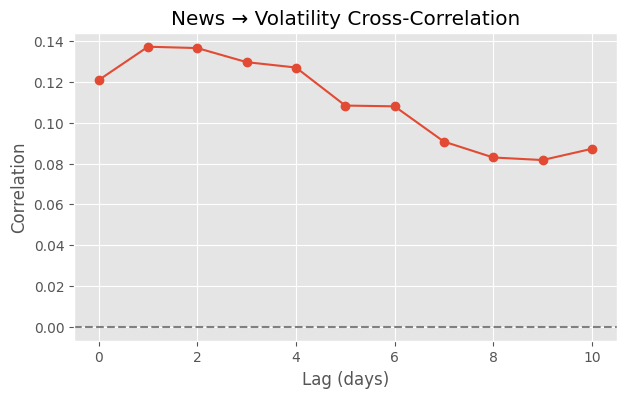

In [28]:
for data, name in zip([corn_df, wheat_df, soybean_df], ["Corn", "Wheat", "Soybean"]):
    merged = data.merge(daily_articles, left_on='time', right_index=True, how='left')
    merged = merged.sort_values('time').reset_index(drop=True)
    merged['news_count'] = merged['news_count'].fillna(0)

    q_low = merged['volatility_7d'].quantile(0.33)
    q_high = merged['volatility_7d'].quantile(0.66)

    merged['vol_regime'] = pd.cut(
        merged['volatility_7d'],
        bins=[-1, q_low, q_high, 1],
        labels=['Low', 'Mid', 'High']
    )

    lags, corr_vol = cross_corr(
        merged['news_count'],
        merged['volatility_7d'],
        max_lag=10
    )
    
    for i, j in zip(lags, corr_vol):
        print(i, j)

    plt.figure(figsize=(7,4))
    plt.plot(lags, corr_vol, marker='o')
    plt.axhline(0, color='gray', linestyle='--')
    plt.xlabel('Lag (days)')
    plt.ylabel('Correlation')
    plt.title('News → Volatility Cross-Correlation')
    plt.show()

- Corn: 뉴스 -> 즉시 불확실성 증가, 방향은 모르지만 가격 흔들림은 커짐
- Wheat: 밀 시장은 뉴스 민감도 매우 높음, 정보가 빠르고 강하게 반영됨
- Soybean: 중간 정도의 크기로 Soybean은 방향 신호가 더 중요 또한, 다른 작물에 비해 뉴스의 수에 관한 상관관계가 빠르게 줄어든다

### 변동성 영역에 따른 뉴스의 수와 +lag 시점의 7일 간의 변동성과의 상관관계

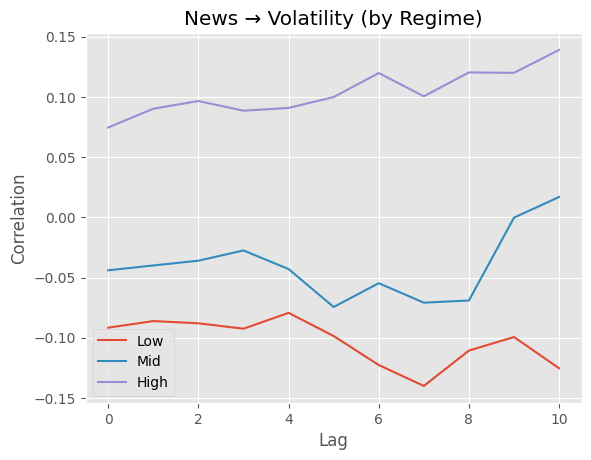

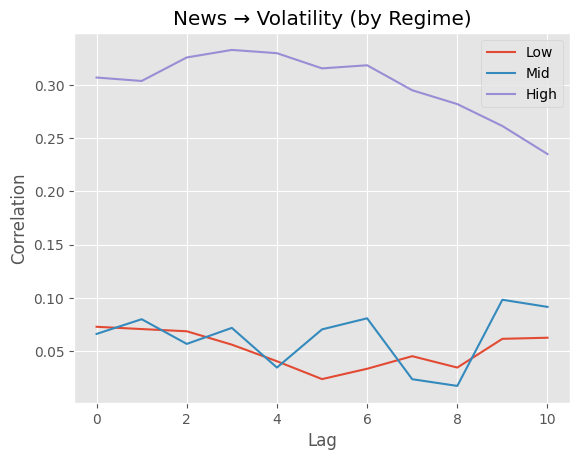

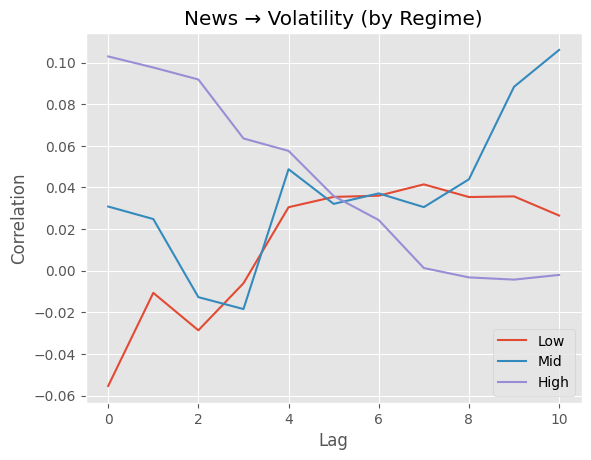

In [29]:
for data, name in zip([corn_df, wheat_df, soybean_df], ["Corn", "Wheat", "Soybean"]):
    merged = data.merge(daily_articles, left_on='time', right_index=True, how='left')
    merged = merged.sort_values('time').reset_index(drop=True)
    merged['news_count'] = merged['news_count'].fillna(0)

    q_low = merged['volatility_7d'].quantile(0.33)
    q_high = merged['volatility_7d'].quantile(0.66)

    merged['vol_regime'] = pd.cut(
        merged['volatility_7d'],
        bins=[-1, q_low, q_high, 1],
        labels=['Low', 'Mid', 'High']
    )

    for regime in ['Low', 'Mid', 'High']:
        sub = merged[merged['vol_regime'] == regime]
        lags, corr = cross_corr(sub['news_count'], sub['volatility_7d'])
    
        plt.plot(lags, corr, label=regime)

    plt.legend()
    plt.xlabel('Lag')
    plt.ylabel('Correlation')
    plt.title('News → Volatility (by Regime)')
    plt.show()

- Cron, Wheat: High regime → 뉴스 민감도가 작물 전체에서 uniformly 높음
- Soybean: 
    - High vol 상태에서는 뉴스가 이미 가격에 선반영 → 추가 lag에서 영향이 줄어듦
    - Low/Mid 상태에서는 뉴스가 점진적으로 불확실성을 쌓음 → lag 유지/증가

## Conclusion

1. 모든 선물에서 전반적인 추세는 없다고 판단
2. 사전에 주어진 filter_status가 실제 선물 가격과 상관 있는 기사를 잘 구분하고 있다고 판단 → 분석에서는 T인 데이터만 가지고 예측하기로 결정
3. 전체 기사의 수가 가격의 변동성을 잘 설명한다고 생각 → 전체 기사의 수를 추가 feature로 활용
4. 뉴스가 변동성에 미치는 영향은 작물별로 다르다고 판단 → 작물별 모델 구축 필요
5. 뉴스는 가격 방향보다는 변동성에 영향을 많이 준다